## **pyTopoComplexity (v0.7.3)**
### **Example for using `pyrugosity` module to calculate rugosity index** 

The module `pyrugosity` measure rugosity index of the land surface, which is widely used to assess landscape structural complexity. The development of this module is influenced by another open-source tool [`Rugosity_Calculator`](https://github.com/drk944/Rugosity_Calculator) created by [drk944](https://github.com/drk944). Such method has been applied in classifying seafloor types by marine geologists and geomorphologist, small-scale hydrodynamics by oceanographers, and studying available habitats in the landscape by ecologists and coral biologists.

To use this code, please cite the Zenodo repository that hosts the latest release of this code: 
* Lai, L. S.-H. (2024). pyTopoComplexity. Zenodo. https://doi.org/10.5281/zenodo.11239338
* Github repository: https://github.com/GeoLarryLai/pyTopoComlexity
<hr>

### **Theory**

The rugosity index is determined as the ratio of the real surface area to the geometric surface area, highlighting smaller-scale variations in surface height. This module adapt triangulated irregular networks method ([Jenness, 2004](https://doi.org/10.2193/0091-7648(2004)032[0829:CLSAFD]2.0.CO;2)), which approximate the surface area of with within each 9 cell as the sum of 8 truncated-triangle area connecting each cell centerpoint with the centerpoints of the 8 surrounding cells within a $N \times N$ moving window:

$$
\text{Rugosity Index} = \frac{\text{real surface area}}{\text{planimetric area}}
$$

The geometric surface area is assumed to be the planimetric area of the center cell. By definition, the rugosity index is as a minimum value of one (completely flate surface). Typical valuesrange from one to three although larger values are possible in very steep terrains. 
<hr>

### **References**
##### Journal Articles: 
* Jenness, J.S. (2004), Calculating landscape surface area from digital elevation models. Wildlife Society Bulletin, 32: 829-839. https://doi.org/10.2193/0091-7648(2004)032[0829:CLSAFD]2.0.CO;2
* Wilson, M.F.J., O’Connell, B., Brown, C., Guinan, J.C., Grehan, A.J., 2007. Multiscale Terrain Analysis of Multibeam Bathymetry Data for Habitat Mapping on the Continental Slope. Marine Geodesy 30, 3-35. https://doi.org/10.1080/01490410701295962 
* Du Preez, C. A new arc–chord ratio (ACR) rugosity index for quantifying three-dimensional landscape structural complexity. Landscape Ecol 30, 181–192 (2015). https://doi.org/10.1007/s10980-014-0118-8

##### Digital Elevation Model (DEM) Examples:
* Washington Geological Survey, 2023. 'Stillaguamish 2014' and 'Snohoco Hazel 2006' projects [lidar data]: originally contracted by Washington State Department of Transportation (WSDOT). [accessed April 4, 2024, at http://lidarportal.dnr.wa.gov]
<hr>

#### 1. Import raster

In [1]:
import os

# File handling
base_dir = os.getcwd()  # Change the directory of base folder as needed
base_dir = os.path.join(base_dir, 'ExampleDEM')
input_file = 'Ososlid2014_f_6ftgrid.tif'
input_dir = os.path.join(base_dir, input_file)

#### 2. Run pyrugosity analysis

In [2]:
from pytopocomplexity import pyrugosity

# Create an instance of pyrugosity
rgty = pyrugosity(chunk_processing=True, chunksize=(512, 512))

# Run analysis using pyrugosity module
Z, result, meta, window_m = rgty.analyze(input_dir, window_size = 17)
#window_size must be an odd number and >= 3 (default is set to 3)
#returned 'window_m' will always be in meters, calculated from defined 'window_size' and the grid spacing of the input raster

[########################################] | 100% Completed | 1.59 sms


#### 3. Export results

In [3]:
# Generate output file name
output_file = os.path.splitext(input_file)[0] + f'_pyRugosity({round(window_m, 2)}m).tif'
output_dir = os.path.join(base_dir, output_file)

# Export the result using pyrugosity module
rgty.export_result(result, meta, output_dir)

Processed result saved to Ososlid2014_f_6ftgrid_pyRugosity(31.09m).tif


#### 4. Display results

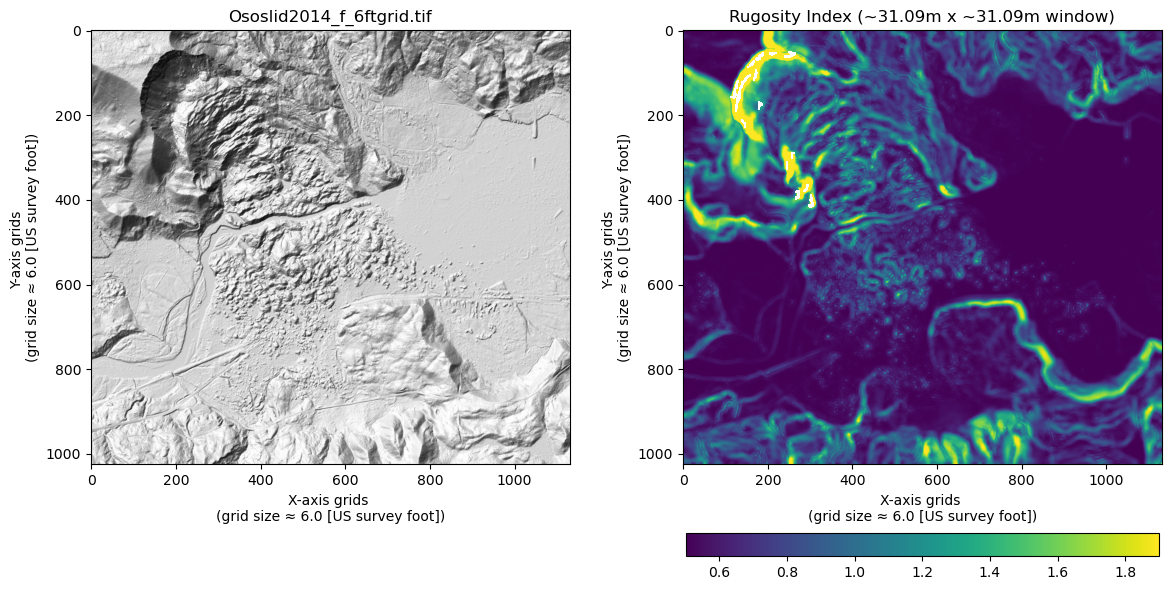

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# Get CRS information for plotting
with rasterio.open(input_dir) as src:
    transform = src.transform
    crs = src.crs

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the hillshade
ls = LightSource(azdeg=315, altdeg=45)
hs = axes[0].imshow(ls.hillshade(Z, vert_exag=2), cmap='gray')
axes[0].set_title(input_file)
axes[0].set_xlabel(f'X-axis grids \n(grid size ≈ {round(transform[0],4)} [{crs.linear_units}])')
axes[0].set_ylabel(f'Y-axis grids \n(grid size ≈ {-round(transform[4],4)} [{crs.linear_units}])')
cbar1 = fig.colorbar(hs, ax=axes[0], orientation='horizontal', fraction=0.045, pad=0.13)
cbar1.ax.set_visible(False)

# Plot the 2D-CWT roughness
im = axes[1].imshow(result, cmap='viridis')
im.set_clim(round(np.nanpercentile(result, 1), 2), round(np.nanpercentile(result, 99), 2))
axes[1].set_title(f'Rugosity Index (~{round(window_m, 2)}m x ~{round(window_m, 2)}m window)')
axes[1].set_xlabel(f'X-axis grids \n(grid size ≈ {round(transform[0],4)} [{crs.linear_units}])')
axes[1].set_ylabel(f'Y-axis grids \n(grid size ≈ {-round(transform[4],4)} [{crs.linear_units}])')
cbar2 = fig.colorbar(im, ax=axes[1], orientation='horizontal', fraction=0.045, pad=0.13)

plt.tight_layout()
plt.savefig('pyrugosity.png', dpi=200, bbox_inches='tight')
plt.show()